In [14]:
#File description & paths to csv's
"""
Code is divided into the following sections:
1. Import data & create dataframes:
    -credit_records_o contains credit_records from csv file, same structure as in the file
    -application_records_o contains data from application csv, file same structure as in the file
    -credit_records_p is wide form of credit_records_o 
2. Enrich credit data with start, end, duration, count of individual statues (0_count, 1_count... 5 ratio) and count all statuses (all_late_count),
ratio of individual status (0_ratio, 1_ratio... 5_ratio) and all late statuse ratio (all_later_ratio)
    - credit_records_p_labelled 
3. Merge app & labelled credit data and calculate bins for discrete variables (birth date, employment date & amount income)
    - app_and_credit_label_2
4. Application functions to take & store user input from ipywidgets
5. Application engine taking filters & drawing graphs:
    - use final_layout to make it run
6. Compare feature pairs (FLAG PHONE with other) in tables & charts

"""

path_to_credit_records_csv='C:\\Users\\User\\OneDrive\\Desktop\\Kurs\\Projekt\\Python\\Dane\\credit_record.csv' #replace with your path to credit records.csv
path_to_application_records_csv='C:\\Users\\User\\OneDrive\\Desktop\\Kurs\\Projekt\\Python\\Dane\\application_record.csv' #replace with your path to credit records.csv

In [3]:
### 1. Import of data & dataframe def 
import csv
import pandas as pd

#create credit_records_o from data in csv
file=open(path_to_credit_records_csv) 
credit_records_o=pd.read_csv(file) 
file.close()

#create application_records_o from data in csv
file=open(path_to_application_records_csv) 
application_records_o=pd.read_csv(file) 
file.close()

#create wide version of credit_records
credit_records_p=pd.pivot(credit_records_o, index='ID',columns='MONTHS_BALANCE',values='STATUS') 
credit_records_p = credit_records_p[credit_records_p.columns.sort_values(ascending=False)] #reorder months balance column in descending order

In [4]:
### 2. Enrich credit data and define labels 

from collections import Counter
p=credit_records_p.copy() 

#add colulmns with val_count(count of statuses), start (first month of loan), end (last month of loan), duration (loan duration)
p['val_count']=p.apply(lambda x: Counter(x),axis=1) 
grouped_id=credit_records_o.groupby('ID')
p['start_mth']=grouped_id['MONTHS_BALANCE'].min()
p['end_mth']=grouped_id['MONTHS_BALANCE'].max()
p['duration']=abs(p['start_mth']-p['end_mth'])+1 

#add columns with 0,1,2,3,4,5 statuses count and their ratios per client
p['0_count']=p['val_count'].apply(lambda x: x.get('0',0)) 
p['0_ratio']=p['0_count']/p['duration'] 
p['1_count']=p['val_count'].apply(lambda x: x.get('1',0)) 
p['1_ratio']=p['1_count']/p['duration'] 
p['2_count']=p['val_count'].apply(lambda x: x.get('2',0))
p['2_ratio']=p['2_count']/p['duration'] 
p['3_count']=p['val_count'].apply(lambda x: x.get('3',0))
p['3_ratio']=p['3_count']/p['duration'] 
p['4_count']=p['val_count'].apply(lambda x: x.get('4',0))
p['4_ratio']=p['4_count']/p['duration'] 
p['5_count']=p['val_count'].apply(lambda x: x.get('5',0))
p['5_ratio']=p['5_count']/p['duration'] 
p['all_late_count']=p['val_count'].apply(lambda x: x.get('0',0)+x.get('1',0)+x.get('2',0)+x.get('3',0)+x.get('4',0)+x.get('5',0)) 
p['all_late_ratio']=p['all_late_count']/p['duration'] 

credit_records_p_labelled=p.copy()

In [5]:
### 3. Merge app & labelled credit data
app_and_credit_label_2=application_records_o.merge(credit_records_p_labelled,on='ID')

app_and_credit_label_2['income_bin']=pd.cut(app_and_credit_label_2['AMT_INCOME_TOTAL'],bins=20)
app_and_credit_label_2['age']=round((app_and_credit_label_2['DAYS_BIRTH']/365),0)
app_and_credit_label_2['length_of_empl']=round((app_and_credit_label_2['DAYS_EMPLOYED']/365),0)

In [6]:
### 4. Application functions

features=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']

def_code_gender=app_and_credit_label_2['CODE_GENDER'].unique()
features_excluded=['val_count', 'start_mth', 'end_mth', 'duration', 'all_late_count', 'all_late_ratio', 'cr_late_bin', 'cr_income_bin', 'default','default_f']

def set_filter(dic: dict):
    """ This function constructs a dictionary representation of user selection.
    i.e if user selected: 'CODE_GENDER': 'M','FLAG_OWN_CAR': 'Y','CNT_CHILDREN': 1, the output will be:
    {'ID': None, 'CODE_GENDER': 'M', 'FLAG_OWN_CAR': 'Y', 'FLAG_OWN_REALTY': None, 'CNT_CHILDREN': 1, 'AMT_INCOME_TOTAL': None, 'NAME_INCOME_TYPE': None, 'NAME_EDUCATION_TYPE': None, 'NAME_FAMILY_STATUS': None, 'NAME_HOUSING_TYPE': None, 'DAYS_BIRTH': None, 'DAYS_EMPLOYED': None, 'FLAG_MOBIL': None, 'FLAG_WORK_PHONE': None, 'FLAG_PHONE': None, 'FLAG_EMAIL': None, 'OCCUPATION_TYPE': None, 'CNT_FAM_MEMBERS': None}
    """
    #construct curr_filter dictionary with None values for all features
    features=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
    values=[None]*len(features)
    curr_filter=dict(zip(features,values))
    #read what was provided in dic and set those keys only to sth
    for key, val in dic.items():
        #print(key,val)
        curr_filter[key]=val
    return curr_filter

def gen_condition_str(filter: dict):
    """ This function takes a list of keys & values and makes a qeury out of them.
    I.e. {'ID': None, 'CODE_GENDER': 'M', 'FLAG_OWN_CAR': 'Y', 'FLAG_OWN_REALTY': None, 'CNT_CHILDREN': 1, 'AMT_INCOME_TOTAL': None, 'NAME_INCOME_TYPE': None, 'NAME_EDUCATION_TYPE': None, 'NAME_FAMILY_STATUS': None, 'NAME_HOUSING_TYPE': None, 'DAYS_BIRTH': None, 'DAYS_EMPLOYED': None, 'FLAG_MOBIL': None, 'FLAG_WORK_PHONE': None, 'FLAG_PHONE': None, 'FLAG_EMAIL': None, 'OCCUPATION_TYPE': None, 'CNT_FAM_MEMBERS': None}
    will return: CODE_GENDER == 'M' & FLAG_OWN_CAR == 'Y' & CNT_CHILDREN == 1 which can be used in df.query
    """
    query=" & ".join(f"{key} == {repr(val)}" for key,val in filter.items() if val!=None and key!='income_bin') #dynamic column & values filtering where columns can take string values - must use the repr function https://www.semicolonworld.com/question/59812/dynamically-filtering-a-pandas-dataframe
    if filter['income_bin']==None:
        return query
    else:
        if len(query)==0:
            query="income_bin.astype('str') == '{}'".format(filter['income_bin'])
            return query
        else:
            query=query + " & income_bin.astype('str') == '{}'".format(filter['income_bin'])
            return query

In [7]:
### 5. Application engine
import ipywidgets as widgets
import matplotlib.pyplot as plt


#Define widgets to get user input
sex = widgets.Dropdown(options=['M','F',None],value=None, description='Sex')
car = widgets.Dropdown(options=['N','Y',None], value=None, description='Own Car')
realty = widgets.Dropdown(options=['N','Y',None], value=None, description='Own Realty')
children = widgets.Dropdown(options=[*range(11),None],value=None,description="Childrens Number")
t=app_and_credit_label_2['income_bin'].sort_values().unique()
income_amt=widgets.Dropdown(options=[*t,None],value=None, description='Yearly Income')
income_type =widgets.Dropdown(options=['State servant', 'Student', 'Commercial associate', 'Pensioner', 'Working',None],value=None, description='Income_type')# b = widgets.IntSlider(description='b')
education_type = widgets.Dropdown(options=['Incomplete higher', 'Academic degree', 'Higher education', 'Secondary / secondary special', 'Lower secondary',None],value=None, description='Education')
family_status = widgets.Dropdown(options=['Widow', 'Married', 'Single / not married', 'Civil marriage', 'Separated',None],value=None,description='Family Status')
housting_type= widgets.Dropdown(options=['Municipal apartment', 'Office apartment','House / apartment','With parents','Co-op apartment','Rented apartment',None],value=None, description="Housing Type")
birth_date = widgets.Dropdown(options=[*range(18,100,1),None], value=None, description="Birth Date")
employment_date = widgets.Dropdown(options=[*range(0,50,1),None], value=None, description="Employment Date")
occupation_type = widgets.Dropdown(options=['High skill tech staff','Private service staff','Managers','Sales staff','Secretaries','IT staff','Realty agents','HR staff','Low-skill Laborers','Accountants',
 'Waiters/barmen staff', 'Core staff', 'Cleaning staff', 'Medicine staff', 'Drivers', 'Laborers','Cooking staff','Security staff',None],value=None,description="Occupation")
submit_button=widgets.Button(description='Submit')

#Below is just a list of dataframe columns and ones that were added to widgets and those that weren't
Columns_Full=['ID', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'age', 'length_of_empl', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE','CNT_FAM_MEMBERS']
Columns_Ommitted=['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','CNT_FAM_MEMBERS','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED']

#capture all values of widgets
def read_values():
    """Captures values of all widgets and returns them as dictionary e.g. {'CODE_GENDER':'M, 'FLAG_OWN_CAR':'Y'...}"""
    dic_keys=['CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN','income_bin','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE', 'age', 'length_of_empl', 'OCCUPATION_TYPE']
    dic_values=[sex.value, car.value ,realty.value ,children.value,income_amt.value,income_type.value,education_type.value,family_status.value,housting_type.value,
    -1*birth_date.value if birth_date.value!=None else None, -1*employment_date.value if employment_date.value!=None else None, occupation_type.value]
    return dict(zip(dic_keys,dic_values))

#Print values of widgest on change of any of them
def print_values(a,b,c,d,e,f,g,h,i,j,k,l):
    """Print current values of widgets"""
    print(print(read_values()))
values_of_widgets = widgets.interactive_output(print_values,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

#Print condition generated on back of dictionary of widgets values
def print_condition(a,b,c,d,e,f,g,h,i,j,k,l):
    """Print condition based on values of widgets"""
    print(print(gen_condition_str(read_values())))
condition_generated = widgets.interactive_output(print_condition,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

###########################################HISTOGRAM PLOTS
#Plots a unfiltered chart on all values
def plot_unfiltered():
    data=app_and_credit_label_2['all_late_ratio']
    mean_v=app_and_credit_label_2['all_late_ratio'].mean()
    plt.hist(app_and_credit_label_2['all_late_ratio'],density=True,label="Late ratio. Records {}. Mean late {:.2f}".format(len(data),mean_v))
    plt.legend()
    plt.show()
chart_unfiltered = widgets.interactive_output(plot_unfiltered, {})

#Plots a chart filtered down to user selection via widgets and also prints in legend number of records meeting selection criteria
def plot_filtered(a,b,c,d,e,f,g,h,i,j,k,l):
    """Plots all_late_ratio with data filtered to the one selected on widgets"""
    if len(gen_condition_str(read_values()))!=0: #check if there is any condition if not it will plot all records
        data=app_and_credit_label_2.query(gen_condition_str(read_values()),engine='python')['all_late_ratio']
        if len(data)!=0: #checks if there is any data in the intersection of user seleciton if not will print msg saying theres none
            mean_v=data.mean()
            plt.hist(data,density=True,label="Late ratio. Records: {}, Mean {:.2f}".format(len(data),mean_v))
            plt.legend()
            plt.show()
        else:
            print('There are no records in this selection')
    else:
        plt.hist(app_and_credit_label_2['all_late_ratio'],density=True,label="Late ratio on filtered records ({})".format(len(app_and_credit_label_2)),bins=10)
        plt.legend()
        plt.show()

chart_filtered = widgets.interactive_output(plot_filtered,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

###########################################Box Plots
#Plots a unfiltered chart on all values
def plot_unfiltered_box():
    plt.boxplot(app_and_credit_label_2['all_late_ratio'])
    plt.show()
chart_unfiltered_box = widgets.interactive_output(plot_unfiltered_box, {})

#Plots a chart filtered down to user selection via widgets and also prints in legend number of records meeting selection criteria
def plot_filtered_box(a,b,c,d,e,f,g,h,i,j,k,l):
    """Plots all_late_ratio with data filtered to the one selected on widgets"""
    if len(gen_condition_str(read_values()))!=0:
        data=app_and_credit_label_2.query(gen_condition_str(read_values()))['all_late_ratio']
        plt.boxplot(data)
        plt.show()
    else:
        plt.boxplot(app_and_credit_label_2['all_late_ratio'])
        plt.show()

chart_filtered_box = widgets.interactive_output(plot_filtered_box,{'a':sex,'b': car, 'c':realty, 'd':children, 'e':income_amt,'f':income_type,'g':education_type,'h':family_status,'i':housting_type, 
        'j':birth_date,'k': employment_date,'l':occupation_type})

#Construct layout of on vertical box contatining a number of horizontal boxes that contain widgets
input_widgets=widgets.VBox([
    widgets.HBox([sex, realty, car]),
    widgets.HBox([children,income_type,education_type]),
    widgets.HBox([family_status, housting_type,occupation_type]),
    widgets.HBox([birth_date,employment_date,income_amt]),
    # widgets.HBox([values_of_widgets]),
    # widgets.HBox([condition_generated])
    ])

chart_widgets_hist=widgets.HBox([chart_unfiltered,chart_filtered])
chart_widgets_box=widgets.HBox([chart_unfiltered_box,chart_filtered_box])

final_layout=widgets.VBox([input_widgets,chart_widgets_hist,chart_widgets_box])

final_layout


mean            count      
FLAG_PHONE          0         1      0     1
CODE_GENDER                                 
F            0.494362  0.481329  17018  7412
M            0.478587  0.499994   8691  3336

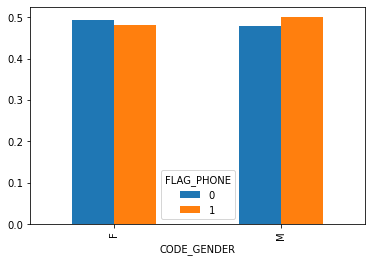

mean           count      
FLAG_PHONE           0        1      0     1
FLAG_OWN_CAR                                
N             0.492485  0.48758  15834  6780
Y             0.483490  0.48634   9875  3968

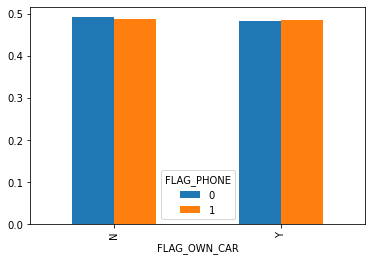

mean            count      
FLAG_PHONE              0         1      0     1
FLAG_OWN_REALTY                                 
N                0.478302  0.485189   7908  4043
Y                0.493795  0.488288  17801  6705

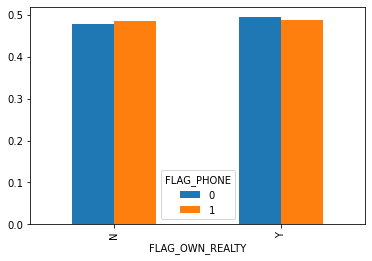

mean              count        
FLAG_PHONE           0         1        0       1
CNT_CHILDREN                                     
0             0.490242  0.487969  17628.0  7573.0
1             0.482237  0.495399   5406.0  2086.0
2             0.496862  0.460447   2290.0   966.0
3             0.494185  0.503081    311.0   108.0
4             0.456115  0.472081     52.0    11.0
5             0.299043  0.431373     19.0     1.0
7                  NaN  0.521739      NaN     2.0
14            0.864407       NaN      3.0     NaN
19                 NaN  1.000000      NaN     1.0

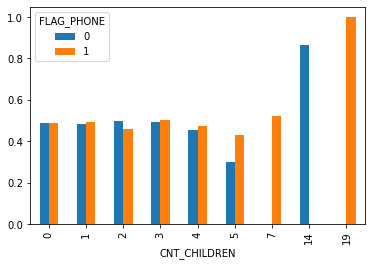

mean              count        
FLAG_PHONE                   0         1        0       1
NAME_INCOME_TYPE                                         
Commercial associate  0.487899  0.489505   5994.0  2496.0
Pensioner             0.495116  0.493242   4376.0  1776.0
State servant         0.486820  0.470543   2127.0   858.0
Student               0.270285       NaN     11.0     NaN
Working               0.488064  0.486660  13201.0  5618.0

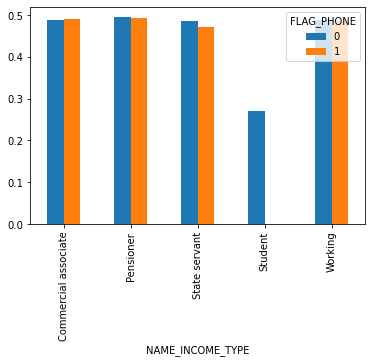

mean            count      
FLAG_PHONE                            0         1      0     1
NAME_EDUCATION_TYPE                                           
Academic degree                0.175162  0.654081     20    12
Higher education               0.469562  0.469680   6693  3171
Incomplete higher              0.506035  0.457709    882   528
Lower secondary                0.458530  0.408126    287    87
Secondary / secondary special  0.496340  0.498015  17827  6950

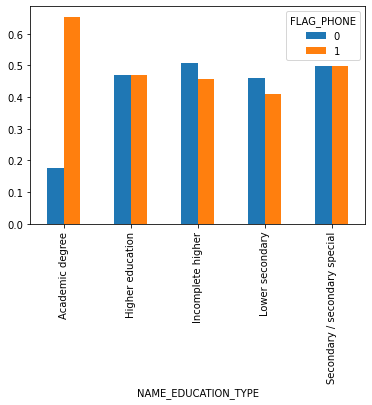

mean            count      
FLAG_PHONE                   0         1      0     1
NAME_FAMILY_STATUS                                   
Civil marriage        0.474092  0.509860   2155   790
Married               0.488540  0.484172  17449  7599
Separated             0.471943  0.478130   1420   683
Single / not married  0.499274  0.498611   3623  1206
Widow                 0.515288  0.480190   1062   470

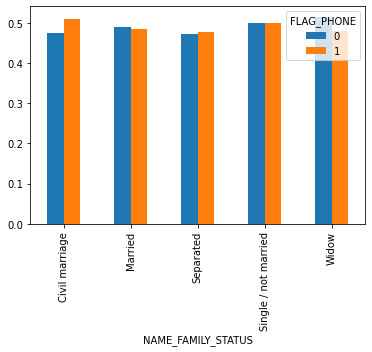

mean            count      
FLAG_PHONE                  0         1      0     1
NAME_HOUSING_TYPE                                   
Co-op apartment      0.416961  0.376231    132    36
House / apartment    0.489248  0.487912  22834  9714
Municipal apartment  0.467587  0.522353    786   342
Office apartment     0.491111  0.524469    207    55
Rented apartment     0.499598  0.420728    475   100
With parents         0.501516  0.464875   1275   501

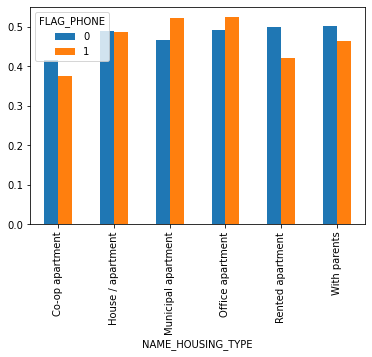

mean            count       
FLAG_PHONE        0         1      0      1
FLAG_MOBIL                                 
1           0.48903  0.487122  25709  10748

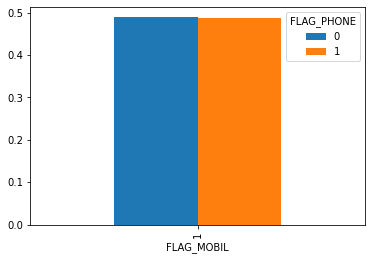

mean            count      
FLAG_PHONE              0         1      0     1
FLAG_WORK_PHONE                                 
0                0.493580  0.487341  22076  6159
1                0.461376  0.486828   3633  4589

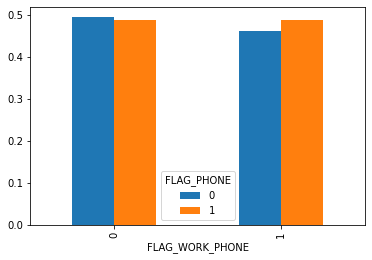

mean            count      
FLAG_PHONE         0         1      0     1
FLAG_EMAIL                                 
0           0.489118  0.485812  23452  9734
1           0.488111  0.499696   2257  1014

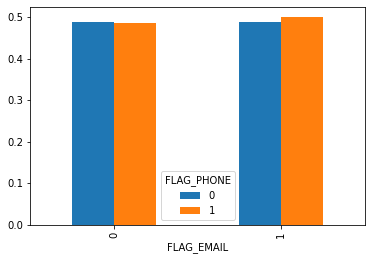

mean           count      
FLAG_PHONE                    0         1     0     1
OCCUPATION_TYPE                                      
Accountants            0.460430  0.442478   795   446
Cleaning staff         0.531754  0.478367   410   141
Cooking staff          0.541001  0.464795   487   168
Core staff             0.478208  0.474939  2484  1107
Drivers                0.486206  0.476851  1514   624
HR staff               0.572760  0.549564    70    15
High skill tech staff  0.477293  0.463921   881   502
IT staff               0.515819  0.536188    44    16
Laborers               0.477228  0.471362  4578  1633
Low-skill Laborers     0.371078  0.570962   120    55
Managers               0.496594  0.475750  2112   900
Medicine staff         0.501608  0.512400   880   327
Private service staff  0.519206  0.474725   225   119
Realty agents          0.573285  0.685348    52    27
Sales staff            0.498513  0.515969  2421  1064
Secretaries            0.443032  0.467153   103    48
Security staff         0.519486  0.616867   471   121
Waiters/barmen staff   0.501978  0.488618   128    46

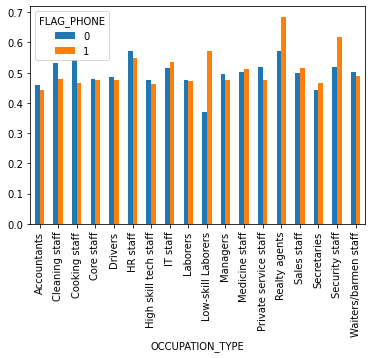

mean              count        
FLAG_PHONE              0         1        0       1
CNT_FAM_MEMBERS                                     
1.0              0.497718  0.493188   5008.0  1979.0
2.0              0.486985  0.484261  13556.0  5907.0
3.0              0.481458  0.501626   4600.0  1821.0
4.0              0.499306  0.465487   2181.0   925.0
5.0              0.491872  0.479200    290.0   107.0
6.0              0.456115  0.280433     52.0     6.0
7.0              0.299043       NaN     19.0     NaN
9.0                   NaN  0.521739      NaN     2.0
15.0             0.864407       NaN      3.0     NaN
20.0                  NaN  1.000000      NaN     1.0

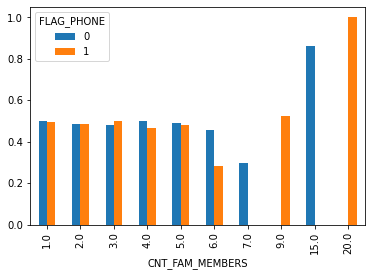

In [15]:
### 6. Table & chart comparison of late ratio vs feature pairs (FLAG PHONE vs ALL)

import matplotlib.pyplot as plt

features_cat=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',  'NAME_FAMILY_STATUS',
'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS']
features_disc= ['AMT_INCOME_TOTAL','DAYS_BIRTH', 'DAYS_EMPLOYED']
features_exl=['FLAG_PHONE']

for el in features_cat:
    display(pd.pivot_table(app_and_credit_label_2,index=el,columns='FLAG_PHONE',values='all_late_ratio',aggfunc=['mean','count']))
    temp_table=pd.pivot_table(app_and_credit_label_2,index=el,columns='FLAG_PHONE',values='all_late_ratio',aggfunc='mean')
    temp_table.plot(kind='bar')
    plt.show()
